In [3]:
import os
import pandas as pd
import numpy as np
import plotnine
from datetime import date
import scipy
import seaborn as sns
from Bio import SeqIO
import matplotlib.pyplot as plt
from upsetplot import from_memberships

In [4]:
## GLOBAL PARAMETERS ##
base_dir = "/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_trials_September21"
eukulele_dir_designer = "EUKulele_designer"
eukulele_dir_CAG = "EUKulele_07-CAG"
eukulele_dir_MAD = "EUKulele_12-MAD"
salmon_dir = os.path.join(base_dir,"08-salmon_mapping")
communities = list(range(1,7))

output_date = "2022-01-24"
eukulele_prot_annots = pd.read_csv(os.path.join("..","data-output", 
                                                "eukulele_prot_annots." + str(output_date) + ".csv"))
eggnog_prot_annots = pd.read_csv(os.path.join("..","data-output", 
                                                "eggnog_prot_annots." + str(output_date) + ".csv"))

In [36]:
## ONLY RUN IF YOU'VE PREVIOUSLY RUN NOTEBOOK ##
curr_date = "2022-01-24"
file_sizes = pd.read_csv(os.path.join("..","data-output", "file_sizes." + curr_date + ".csv"))
file_sizes_short = pd.read_csv(os.path.join("..","data-output", "file_sizes_short." + curr_date + ".csv"))
all_results = pd.read_csv(os.path.join("..","data-output", "all_results." + str(curr_date) + ".csv"))

In [66]:
curr_date = "2022-01-26"

all_eggnog_CAG = pd.read_csv(os.path.join("..","data-output", "all_eggnog_CAG." + str(curr_date) + ".csv"))
all_eggnog_designer = pd.read_csv(os.path.join("..","data-output", "all_eggnog_designer." + str(curr_date) + ".csv"))
all_EUKulele_CAG = pd.read_csv(os.path.join("..","data-output", "all_EUKulele_CAG." + str(curr_date) + ".csv"))
all_eukulele_designer = pd.read_csv(os.path.join("..","data-output", "all_eukulele_designer." + str(curr_date) + ".csv"))

In [6]:
designer_species = dict(zip(eukulele_prot_annots.transcript_name, eukulele_prot_annots.Species))
designer_genera = dict(zip(eukulele_prot_annots.transcript_name, eukulele_prot_annots.Genus))
designer_kos = dict(zip(eggnog_prot_annots["query"],eggnog_prot_annots.KEGG_ko))

In [11]:
## GET THE FILE SIZES TO GENERATE TABLES FOR PAPER ##
file_sizes = pd.DataFrame()
jeukebox_dirs = [curr for curr in os.listdir(base_dir) if "jEUKebox" in curr]
for jeukebox_dir in jeukebox_dirs:
    print(jeukebox_dir,flush=True)
    for comm_num in communities:
        base_dir_covs = os.path.join(base_dir, jeukebox_dir, "clustering",
                                    "clustering_designer","prot")
        coverage_dirs = os.listdir(base_dir_covs)
        all_seq_files = pd.DataFrame()
        for coverage in coverage_dirs:
            cov_curr = coverage.split("_")[-1]
            seq_ids = os.listdir(os.path.join(base_dir_covs,coverage))
            for seq_id in seq_ids:
                seq_curr = seq_id.split("_")[-1]
                seq_file = os.path.join(base_dir_covs,coverage,
                                                                 seq_id,
                                                                 "designer_assembly_" + \
                                    str(comm_num) + ".pep.fasta")
                contig_no = len([r.id for r in SeqIO.parse(seq_file, "fasta")])
                kegg_kos = []
                [kegg_kos.extend(designer_kos[curr.id].split(",")) if curr.id in\
                    designer_kos else "" for curr in SeqIO.parse(seq_file, "fasta")]
                kegg_kos = set(kegg_kos)
                genera = set([designer_genera[curr.id].strip() if curr.id in designer_genera \
                               else "" for curr in SeqIO.parse(seq_file, "fasta")])
                genera = list(genera)
                genera.remove("")
                genera.remove("Unannotated")
                species = set([designer_species[curr.id].strip() if curr.id in designer_species \
                               else "" for curr in SeqIO.parse(seq_file, "fasta")])
                species = list(species)
                species.remove("")
                species.remove("Unannotated")
                file_size = os.path.getsize(seq_file)
            
                mmetsp_group = "B"
                if "100k" in jeukebox_dir:
                    mmetsp_group = "A"

                curr_df = pd.DataFrame({"jEUKebox": [jeukebox_dir],
                                        "DesignerSize": file_size,
                                        "DesignerContigs": contig_no,
                                        "SeqID": seq_id,
                                        "Coverage": coverage,
                                        "Community": comm_num,
                                        "MMETSPGroup": mmetsp_group,
                                        "Species": "-".join(sorted(species)),
                                        "NumSpecies": len(species),
                                        "Genera": "-".join(sorted(genera)),
                                        "NumGenera": len(genera),
                                        # "KOs": kegg_kos,
                                        "NumKOs": len(kegg_kos)})
                file_sizes = pd.concat([file_sizes,curr_df])

jEUKebox-Trial3-CommB
jEUKebox-Trial2-CommB
jEUKebox-Trial4-100k
jEUKebox-Trial2-100k
jEUKebox-Trial1-CommB
jEUKebox-Trial3-100k
jEUKebox-Trial1-100k
jEUKebox-Trial4-CommB


In [24]:
tested_filesizes = file_sizes.groupby(["MMETSPGroup","SeqID","Coverage"]).agg({"NumSpecies":["mean","std"],
                                         "NumGenera":["mean","std"],
                                         "NumKOs":["mean","std"],
                                          "DesignerContigs":["mean","std"],
                                          "DesignerSize":["mean","std"]}).reset_index()

tested_filesizes["SeqID"] = [float(curr.split("seqid_")[-1]) for curr in tested_filesizes["SeqID"]]
tested_filesizes["Coverage"] = [str(curr.split("c_")[-1]) for curr in tested_filesizes["Coverage"]]

tested_filesizes.columns = [' '.join(col).strip() for col in tested_filesizes.columns.values]

# compare to seqID 1 & coverage 1
final_answer = tested_filesizes[(tested_filesizes.SeqID == 1) & \
                                (tested_filesizes.Coverage == "1")].drop_duplicates()
final_answer = final_answer.drop(columns=["SeqID","Coverage"])
final_answer.columns = [curr + "_seqID1_cov1" if curr!="MMETSPGroup" else curr for \
                        curr in final_answer.columns]


tested_filesizes = pd.merge(tested_filesizes,final_answer)
tested_filesizes["CompareKO"] = tested_filesizes["NumKOs mean"] / tested_filesizes["NumKOs mean_seqID1_cov1"]
tested_filesizes["CompareDesignerSize"] = tested_filesizes["DesignerSize mean"] / tested_filesizes["DesignerSize mean_seqID1_cov1"]
tested_filesizes["CompareNumGenera"] = tested_filesizes["NumGenera mean"] / tested_filesizes["NumGenera mean_seqID1_cov1"]

In [ ]:
file_sizes_short = pd.DataFrame()
for jeukebox_dir in jeukebox_dirs:
    sourmash_file = os.path.join(base_dir, jeukebox_dir, "sourmash_MMETSP", "all.csv")
    #if jeukebox_dir == "jEUKebox-Trial2-CommB":
    #    continue
    #print(jeukebox_dir,"starting")
    if os.path.isfile(sourmash_file):
        
        if not os.path.isdir(os.path.join(base_dir, jeukebox_dir, 
                             "sourmash_MMETSP")):
            continue
        #print(jeukebox_dir,"passed sourmash",flush=True)
        sourmash_file = pd.read_csv(os.path.join(base_dir, jeukebox_dir, 
                                                 "sourmash_MMETSP", "all.csv"))
        community_file = pd.read_csv(os.path.join(base_dir, jeukebox_dir, 
                                                  "03-community_spec", "communities.csv"))

        #print(final_scores,flush=True)
        prot_clust_dir = os.path.join(base_dir, jeukebox_dir,
                                      "eukrhythmic_assembly",
                                      "intermediate-files",
                                      "03-merge", "07-CAG")
        if not os.path.isdir(prot_clust_dir):
            continue
            
        for sim_file in os.listdir(prot_clust_dir):
            if "fasta" not in sim_file:
                continue
                
                
            comm_num = sim_file.split("sim_raw_reads_")[-1].split("_")[0]
                
            ## STORED CONTIGS FROM DESIGNER ASSEMBLY
            designer_contigs = os.path.join(base_dir, jeukebox_dir, 
                                                      "06-designer_assemblies",
                                                      "designer_assembly_" + str(comm_num) + ".fasta")
            designer_size = os.path.getsize(designer_contigs)
            des_contig_no = len([r.id for r in SeqIO.parse(designer_contigs, "fasta")])
            
            ## WHAT'S INSIDE THE CAG ASSEMBLY
            cag_assembly = os.path.join(prot_clust_dir,sim_file)
            cag_contig_no = len([r.id for r in SeqIO.parse(cag_assembly, "fasta")])
            cag_size = os.path.getsize(cag_assembly)
            
            mmetsp_group = "B"
            if "100k" in jeukebox_dir:
                mmetsp_group = "A"
            
            curr_df = pd.DataFrame({"jEUKebox": [jeukebox_dir],
                                    "CAGSize": cag_size,
                                    "CAGContigs": cag_contig_no,
                                    "DesignerContigs": des_contig_no,
                                    "DesignerSize": designer_size,
                                    "Community": comm_num,
                                    "MMETSPGroup": mmetsp_group})
            file_sizes_short = pd.concat([file_sizes_short,curr_df])

In [ ]:
file_sizes_short["DesignerMB"] = file_sizes_short.DesignerSize /(1000*1000)
file_sizes_short["CAGMB"] = file_sizes_short.CAGSize /(1000*1000)
file_sizes_short.groupby(["Community","MMETSPGroup"]).agg({"CAGContigs":["mean","std"],
                                                    "DesignerContigs":["mean","std"],
                                                    "DesignerMB":["mean","std"],
                                                    "CAGMB":["mean","std"]}).reset_index()

In [ ]:
file_sizes.to_csv(os.path.join("..","data-output", "file_sizes." + str(date.today()) + ".csv"))
file_sizes_short.to_csv(os.path.join("..","data-output", "file_sizes_short." + str(date.today()) + ".csv"))


In [16]:
file_sizes_short["DesignerMB"] = file_sizes_short.DesignerSize /(1000*1000)
file_sizes_short["CAGMB"] = file_sizes_short.CAGSize /(1000*1000)
file_sizes_short.groupby(["Community","MMETSPGroup"]).agg({"CAGContigs":["mean","std"],
                                                    "DesignerContigs":["mean","std"],
                                                    "DesignerMB":["mean","std"],
                                                    "CAGMB":["mean","std"]}).reset_index()

Community MMETSPGroup CAGContigs              DesignerContigs               \
                               mean          std            mean          std   
0          1           A   61254.50  4277.939808        54388.50  4532.484271   
1          1           B   57724.75  5265.326984        50778.75  7534.182122   
2          2           A   47465.75  5357.416440        47674.25  3176.607769   
3          2           B   51242.25  4351.129537        44273.00  3909.652755   
4          3           A   53644.25  5989.062218        53856.75  4935.725977   
5          3           B   53115.50  8702.311743        44557.00  9013.396659   
6          4           A   57838.50  8582.964387        52556.75  6567.434373   
7          4           B   56685.50  5643.036919        49299.75  7187.776679   
8          5           A   49321.25  5258.357625        46736.25  5071.865953   
9          5           B   50763.50  6235.641346        44349.25  7997.126041   
10         6           A   61751.75  2621.299598        57317.75  2516.000977   
11         6           B   57900.50  4692.335701        50288.50  5909.918697   

   DesignerMB                 CAGMB            
         mean        std       mean       std  
0   80.493421   6.623008  38.390405  2.910068  
1   73.321207  10.152301  34.080347  1.903032  
2   62.032148   6.615879  31.539343  2.630777  
3   61.782970   5.318045  31.863341  1.583908  
4   67.817339   9.531703  33.273037  3.414859  
5   63.576651  15.264669  32.042278  3.138189  
6   69.285972  12.349761  34.698469  4.423010  
7   70.226516  11.486629  33.435458  1.842821  
8   61.636506   5.999034  31.048508  2.250702  
9   58.400730   8.429583  30.954371  1.854299  
10  75.879111   4.493756  36.247078  1.787414  
11  69.814012   9.604308  33.448398  1.773177

In [26]:
tested_filesizes.head()

,MMETSPGroup,SeqID,Coverage,NumSpecies mean,NumSpecies std,NumGenera mean,NumGenera std,NumKOs mean,NumKOs std,DesignerContigs mean,...,NumGenera std_seqID1_cov1,NumKOs mean_seqID1_cov1,NumKOs std_seqID1_cov1,DesignerContigs mean_seqID1_cov1,DesignerContigs std_seqID1_cov1,DesignerSize mean_seqID1_cov1,DesignerSize std_seqID1_cov1,CompareKO,CompareDesignerSize,CompareNumGenera
0,A,0.6,0.6,4.375,1.244553,3.625,0.824226,4803.458333,403.053668,35515.666667,...,0.84699,4866.833333,398.708204,50164.708333,6009.88735,2.912441e+07,4.011265e+06,0.986978,0.727390,0.966667
1,A,0.6,0.75,4.375,1.244553,3.625,0.824226,4808.750000,403.067720,35964.250000,...,0.84699,4866.833333,398.708204,50164.708333,6009.88735,2.912441e+07,4.011265e+06,0.988065,0.733966,0.966667
2,A,0.6,0.8,4.375,1.244553,3.625,0.824226,4811.583333,402.884266,36190.291667,...,0.84699,4866.833333,398.708204,50164.708333,6009.88735,2.912441e+07,4.011265e+06,0.988648,0.737399,0.966667
3,A,0.6,0.9,4.375,1.244553,3.625,0.824226,4820.333333,403.755809,36855.875000,...,0.84699,4866.833333,398.708204,50164.708333,6009.88735,2.912441e+07,4.011265e+06,0.990446,0.747878,0.966667
4,A,0.6,0.95,4.375,1.244553,3.625,0.824226,4826.916667,403.180822,37563.166667,...,0.84699,4866.833333,398.708204,50164.708333,6009.88735,2.912441e+07,4.011265e+06,0.991798,0.760380,0.966667


In [27]:
for_plot = pd.wide_to_long(tested_filesizes,stubnames="Compare",suffix="\D+",j="Type",
                i=["SeqID","Coverage","MMETSPGroup"]).reset_index()

In [28]:
latex_table = tested_filesizes.copy(deep=True)
# pm printed is \u00B1 
latex_table["DesignerContigs"] = [str(int(mean_num)) + " $ \pm $ " + str(int(std_num)) \
                                  for mean_num, std_num in zip(latex_table["DesignerContigs mean"],
                                                               latex_table["DesignerContigs std"])]
latex_table["DesignerSize"] = [str(round(mean_num/10**6, 1)) + " $ \pm $ " + str(round(std_num/10**6, 1)) \
                                  for mean_num, std_num in zip(latex_table["DesignerSize mean"],
                                                               latex_table["DesignerSize std"])]
latex_table["NumGenera"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table["NumGenera mean"],
                                                               latex_table["NumGenera std"])]
latex_table["NumSpecies"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table["NumSpecies mean"],
                                                               latex_table["NumSpecies std"])]
latex_table["NumKOs"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table["NumKOs mean"],
                                                               latex_table["NumKOs std"])]
latex_table = latex_table[["MMETSPGroup","SeqID","Coverage","DesignerContigs","DesignerSize",
                           "NumGenera","NumSpecies","NumKOs"]]

## list of seqID-coverage combos we want in the DF 
combos_desired = ["0.6-0.6", "0.6-1", "0.8-0.8", "1.0-0.6", "1.0-0.8", "1.0-0.95","1.0-0.99", "1.0-1"]
latex_table = latex_table.loc[[str(round(seqid,1)) + "-" + str(coverage) in combos_desired for \
                              seqid,coverage in zip(latex_table.SeqID, latex_table.Coverage)],:]
latex_table["Coverage"] = [str(round(float(curr), 4)) for curr in latex_table.Coverage]
latex_table["SeqID"] = [str(round(float(curr), 4)) for curr in latex_table.SeqID]

latex_formatted = latex_table.to_latex(escape=False,index=False,longtable=True,multicolumn=True,
                     column_format="".join(["p"] * len(latex_table.columns)))

In [54]:
tested_filesizes

,SeqID,Coverage,NumSpecies mean,NumSpecies std,NumGenera mean,NumGenera std,NumKOs mean,NumKOs std,DesignerContigs mean,DesignerContigs std,DesignerSize mean,DesignerSize std
0,0.60,0.6,4.625,1.330893,4.2500,1.296476,4921.125000,376.157087,36970.458333,6190.159002,2.259201e+07,4.122889e+06
1,0.60,0.75,4.625,1.330893,4.2500,1.296476,4925.708333,376.222261,37340.166667,6225.210007,2.275344e+07,4.137152e+06
2,0.60,0.8,4.625,1.330893,4.2500,1.296476,4928.604167,376.243682,37526.791667,6237.942142,2.283869e+07,4.144039e+06
3,0.60,0.9,4.625,1.330893,4.2500,1.296476,4938.166667,376.309647,38096.020833,6282.095654,2.311133e+07,4.170842e+06
4,0.60,0.95,4.625,1.330893,4.2500,1.296476,4945.062500,375.678020,38681.041667,6310.016445,2.342355e+07,4.192838e+06
5,0.60,0.99,4.625,1.330893,4.2500,1.296476,4953.916667,376.807860,39925.937500,6318.247557,2.408354e+07,4.193760e+06
6,0.60,1,4.625,1.330893,4.3125,1.274233,4961.395833,377.205048,41206.270833,6269.723852,2.497208e+07,4.174173e+06
7,0.75,0.6,4.625,1.330893,4.2500,1.296476,4950.375000,378.508081,39211.875000,6546.740390,2.377850e+07,4.332915e+06
8,0.75,0.75,4.625,1.330893,4.2500,1.296476,4954.208333,378.509954,39527.541667,6551.966110,2.390478e+07,4.333343e+06
9,0.75,0.8,4.625,1.330893,4.2500,1.296476,4955.562500,378.149746,39637.541667,6553.047334,2.394323e+07,4.333302e+06


In [59]:
tested_filesizes = file_sizes.groupby(["SeqID","Coverage"]).agg({"NumSpecies":["mean","std"],
                                         "NumGenera":["mean","std"],
                                         "NumKOs":["mean","std"],
                                          "DesignerContigs":["mean","std"],
                                          "DesignerSize":["mean","std"]}).reset_index()

tested_filesizes["SeqID"] = [float(curr.split("seqid_")[-1]) for curr in tested_filesizes["SeqID"]]
tested_filesizes["Coverage"] = [str(curr.split("c_")[-1]) for curr in tested_filesizes["Coverage"]]

tested_filesizes.columns = [' '.join(col).strip() for col in tested_filesizes.columns.values]

# compare to seqID 1 & coverage 1
final_answer = tested_filesizes[(tested_filesizes.SeqID == 1) & \
                                (tested_filesizes.Coverage == "1")].drop_duplicates()
final_answer = final_answer.drop(columns=["SeqID","Coverage"])
final_answer.columns = [curr + "_seqID1_cov1" if curr!="MMETSPGroup" else curr for \
                        curr in final_answer.columns]
final_answer["Extra"]="freebie"
tested_filesizes["Extra"]="freebie"

tested_filesizes = pd.merge(tested_filesizes,final_answer)
tested_filesizes["CompareKO"] = tested_filesizes["NumKOs mean"] / tested_filesizes["NumKOs mean_seqID1_cov1"]
tested_filesizes["CompareDesignerSize"] = tested_filesizes["DesignerSize mean"] / tested_filesizes["DesignerSize mean_seqID1_cov1"]
tested_filesizes["CompareNumGenera"] = tested_filesizes["NumGenera mean"] / tested_filesizes["NumGenera mean_seqID1_cov1"]


latex_table = tested_filesizes.copy(deep=True)
# pm printed is \u00B1 
latex_table["DesignerContigs"] = [str(int(mean_num)) + " $ \pm $ " + str(int(std_num)) \
                                  for mean_num, std_num in zip(latex_table["DesignerContigs mean"],
                                                               latex_table["DesignerContigs std"])]
latex_table["DesignerSize"] = [str(round(mean_num/10**6, 1)) + " $ \pm $ " + str(round(std_num/10**6, 1)) \
                                  for mean_num, std_num in zip(latex_table["DesignerSize mean"],
                                                               latex_table["DesignerSize std"])]
latex_table["NumGenera"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table["NumGenera mean"],
                                                               latex_table["NumGenera std"])]
latex_table["NumSpecies"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table["NumSpecies mean"],
                                                               latex_table["NumSpecies std"])]
latex_table["NumKOs"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table["NumKOs mean"],
                                                               latex_table["NumKOs std"])]
latex_table = latex_table[["SeqID","Coverage","DesignerContigs","DesignerSize",
                           "NumGenera","NumSpecies","NumKOs"]]

## list of seqID-coverage combos we want in the DF 
combos_desired = ["0.6-0.6", "0.6-1", "0.8-0.8", "1.0-0.6", "1.0-0.8", "1.0-0.95","1.0-0.99", "1.0-1"]
latex_table = latex_table.loc[[str(round(seqid,1)) + "-" + str(coverage) in combos_desired for \
                              seqid,coverage in zip(latex_table.SeqID, latex_table.Coverage)],:]
latex_table["Coverage"] = [str(round(float(curr), 4)) for curr in latex_table.Coverage]
latex_table["SeqID"] = [str(round(float(curr), 4)) for curr in latex_table.SeqID]

latex_formatted = latex_table.to_latex(escape=False,index=False,longtable=True,multicolumn=True,
                     column_format="".join(["p"] * len(latex_table.columns)))

print(latex_formatted)

\begin{longtable}{ppppppp}
\toprule
SeqID & Coverage &     DesignerContigs &      DesignerSize &        NumGenera &       NumSpecies &                NumKOs \\
\midrule
\endhead
\midrule
\multicolumn{7}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
  0.6 &      0.6 &  36970 $ \pm $ 6190 &  22.6 $ \pm $ 4.1 &  4.2 $ \pm $ 1.3 &  4.6 $ \pm $ 1.3 &  4921.1 $ \pm $ 376.2 \\
  0.6 &      1.0 &  41206 $ \pm $ 6269 &  25.0 $ \pm $ 4.2 &  4.3 $ \pm $ 1.3 &  4.6 $ \pm $ 1.3 &  4961.4 $ \pm $ 377.2 \\
 0.75 &      0.8 &  39637 $ \pm $ 6553 &  23.9 $ \pm $ 4.3 &  4.2 $ \pm $ 1.3 &  4.6 $ \pm $ 1.3 &  4955.6 $ \pm $ 378.1 \\
  0.8 &      0.8 &  40486 $ \pm $ 6608 &  24.4 $ \pm $ 4.4 &  4.3 $ \pm $ 1.3 &  4.6 $ \pm $ 1.3 &  4960.9 $ \pm $ 378.6 \\
 0.99 &      0.6 &  46662 $ \pm $ 6683 &  27.9 $ \pm $ 4.5 &  4.3 $ \pm $ 1.3 &  4.6 $ \pm $ 1.3 &  4988.3 $ \pm $ 375.5 \\
 0.99 &      0.8 &  46742 $ \pm $ 6682 &  28.0 $ \pm $ 4.5 &  4.3 $ \pm $ 1.3 &  4.6 $ \pm $ 1.3 &  4

In [95]:
num_contigs_assembly = all_results.drop_duplicates(subset=["Representative","Name","Community"],keep="first").\
    groupby(["Community","Name"])["Representative"].count().reset_index().\
    groupby(["Community"]).agg({"Representative": ["mean","std"]}).reset_index()

num_contigs_assembly.columns = [' '.join(col).strip() for col in num_contigs_assembly.columns.values]

#num_contigs_assembly["MMETSPGroup"] = ["A" if "100k" in curr else "B" for curr in num_contigs_assembly["Name"]]
num_contigs_assembly["ContigsCAG"] = [str(int(me)) + " $ \pm $ " + str(int(st)) for \
                            me,st in zip(num_contigs_assembly["Representative mean"],
                                         num_contigs_assembly["Representative std"])]


def set_unique(x):
    return (list(set(x))) 

def count_unique(x):
    return len(list(set(x)))
#all_EUKulele_CAG["MMETSPGroup"] = ["A" if "100k" in curr else "B" for curr in all_EUKulele_CAG["Name"]]
all_EUKulele_CAG["GenusStrip"] = [curr.strip() for curr in all_EUKulele_CAG.Genus]
all_EUKulele_CAG["SpeciesStrip"] = [curr.strip() for curr in all_EUKulele_CAG.Species]
count_cag_eukulele = all_EUKulele_CAG.groupby(["Community","Name"])[["GenusStrip",
                                                                                   "SpeciesStrip"]].\
    agg(lambda x: count_unique(x)).reset_index().\
    groupby(["Community"]).agg({"GenusStrip":["mean","std"],
                                              "SpeciesStrip":["mean","std"]})

count_cag_eukulele.columns = [' '.join(col).strip() for col in count_cag_eukulele.columns.values]

all_eukulele_designer["GenusStrip"] = [curr.strip() for curr in all_eukulele_designer.Genus]
all_eukulele_designer["SpeciesStrip"] = [curr.strip() for curr in all_eukulele_designer.Species]
#all_eukulele_designer["MMETSPGroup"] = ["A" if "100k" in curr else "B" for curr in all_eukulele_designer["Name"]]
count_des_eukulele = all_eukulele_designer.groupby(["Community","Name"])[["GenusStrip",
                                                                                        "SpeciesStrip"]].\
    agg(lambda x: count_unique(x)).reset_index().\
    groupby(["Community"]).agg({"GenusStrip":["mean","std"],
                                              "SpeciesStrip":["mean","std"]})

count_des_eukulele.columns = [' '.join(col).strip() for col in count_des_eukulele.columns.values]

count_des_eukulele["GenusDes"] = [str(round(me,1)) + " $ \pm $ " + str(round(st,1)) for \
                            me,st in zip(count_des_eukulele["GenusStrip mean"], count_des_eukulele["GenusStrip std"])]

count_des_eukulele["SpeciesDes"] = [str(round(me,1)) + " $ \pm $ " + str(round(st,1)) for \
                            me,st in zip(count_des_eukulele["SpeciesStrip mean"], count_des_eukulele["SpeciesStrip std"])]

count_cag_eukulele["GenusCAG"] = [str(round(me,1)) + " $ \pm $ " + str(round(st,1)) for \
                            me,st in zip(count_cag_eukulele["GenusStrip mean"], count_cag_eukulele["GenusStrip std"])]
count_cag_eukulele["SpeciesCAG"] = [str(round(me,1)) + " $ \pm $ " + str(round(st,1)) for \
                            me,st in zip(count_cag_eukulele["SpeciesStrip mean"], count_cag_eukulele["SpeciesStrip std"])]

for_latex = pd.merge(pd.merge(count_des_eukulele.reset_index()[["Community","GenusDes","SpeciesDes"]],
           count_cag_eukulele.reset_index()[["Community",
                                             "GenusCAG","SpeciesCAG"]]),\
        latex_table_comm[["DesignerContigs","DesignerSize","Community","NumGenera","NumSpecies"]]\
        )[["Community","DesignerContigs","DesignerSize","NumGenera","GenusDes",
                                     "GenusCAG","NumSpecies","SpeciesDes","SpeciesCAG"]]

la_print = for_latex.\
    to_latex(escape=False,index=False)

def set_unique(x):
    return (list(set(x))) 

def count_unique(x):
    return len(list(set(x)))

all_eggnog_CAG_explode = all_eggnog_CAG.explode('KEGG_ko')
#all_eggnog_CAG_explode["MMETSPGroup"] = ["A" if "100k" in curr else "B" for curr in all_eggnog_CAG_explode["Name"]]
all_eggnog_CAG_explode["KEGG_koStrip"] = [curr.strip() for curr in all_eggnog_CAG_explode.KEGG_ko]
#all_eggnog_CAG_explode["MMETSPGroup"] = ["A" if "100k" in curr else "B" for curr in all_eggnog_CAG_explode["Name"]]
count_cag_eggnog = all_eggnog_CAG_explode.groupby(["Community","Name"])[["KEGG_koStrip"]].\
    agg(lambda x: count_unique(x)).reset_index().\
    groupby(["Community"]).agg({"KEGG_koStrip":["mean","std"]})

count_cag_eggnog.columns = [' '.join(col).strip() for col in count_cag_eggnog.columns.values]

all_eggnog_designer_explode = all_eggnog_designer.explode('KEGG_ko')
#all_eggnog_designer_explode["MMETSPGroup"] = ["A" if "100k" in curr else "B" for curr in all_eggnog_designer_explode["Name"]]
all_eggnog_designer_explode["KEGG_koStrip"] = [curr.strip() for curr in all_eggnog_designer_explode.KEGG_ko]
#all_eggnog_designer_explode["MMETSPGroup"] = ["A" if "100k" in curr else "B" for curr in all_eggnog_designer_explode["Name"]]
count_des_eggnog = all_eggnog_designer_explode.groupby(["Community","Name"])[["KEGG_koStrip"]].\
    agg(lambda x: count_unique(x)).reset_index().\
    groupby(["Community"]).agg({"KEGG_koStrip":["mean","std"]})

count_des_eggnog.columns = [' '.join(col).strip() for col in count_des_eggnog.columns.values]

count_des_eggnog["KODes"] = [str(round(me,1)) + " $ \pm $ " + str(round(st,1)) for \
                            me,st in zip(count_des_eggnog["KEGG_koStrip mean"],
                                         count_des_eggnog["KEGG_koStrip std"])]

count_cag_eggnog["KOCAG"] = [str(round(me,1)) + " $ \pm $ " + str(round(st,1)) for \
                            me,st in zip(count_cag_eggnog["KEGG_koStrip mean"],
                                         count_cag_eggnog["KEGG_koStrip std"])]

for_latex = pd.merge(pd.merge(count_des_eggnog.reset_index()[["Community","KODes"]],
           count_cag_eggnog.reset_index()[["Community","KOCAG"]]),for_latex)\
            [["Community","DesignerContigs","DesignerSize","NumGenera","GenusDes",
                                     "GenusCAG","NumSpecies","SpeciesDes","SpeciesCAG","KODes","KOCAG"]]

for_latex = pd.merge(for_latex,num_contigs_assembly)[["Community","DesignerContigs",
                                                      "DesignerSize",
                                                      "ContigsCAG","NumGenera","GenusDes",
                                                      "GenusCAG","NumSpecies","SpeciesDes",
                                                      "SpeciesCAG","KODes","KOCAG"]]
for_latex["Community"] = [str(numcom) for numcom in list(for_latex.Community)]
for_latex = for_latex[["Community","DesignerContigs","DesignerSize",
                       "ContigsCAG","NumGenera","GenusDes",
                       "GenusCAG","NumSpecies","SpeciesDes","SpeciesCAG","KODes","KOCAG"]]

la_print = for_latex.\
    to_latex(escape=False,index=False)

In [96]:
set(for_latex.Community)

{'1', '2', '3', '4', '5', '6'}

In [97]:
print(la_print)

\begin{tabular}{llllllllllll}
\toprule
Community &     DesignerContigs &      DesignerSize &          ContigsCAG &        NumGenera &          GenusDes &           GenusCAG &       NumSpecies &        SpeciesDes &        SpeciesCAG &                 KODes &                 KOCAG \\
\midrule
        1 &  51741 $ \pm $ 6031 &  32.6 $ \pm $ 3.6 &  59489 $ \pm $ 4825 &  3.8 $ \pm $ 0.5 &  17.9 $ \pm $ 6.2 &  40.0 $ \pm $ 11.5 &  3.9 $ \pm $ 0.4 &  17.4 $ \pm $ 3.5 &  30.4 $ \pm $ 5.9 &  3435.1 $ \pm $ 429.6 &  1941.2 $ \pm $ 161.5 \\
        2 &  44180 $ \pm $ 3486 &  26.1 $ \pm $ 2.6 &  49354 $ \pm $ 4948 &  3.2 $ \pm $ 0.9 &  16.4 $ \pm $ 7.5 &  33.8 $ \pm $ 12.8 &  3.4 $ \pm $ 0.7 &  14.5 $ \pm $ 4.8 &  24.0 $ \pm $ 8.4 &  3422.5 $ \pm $ 412.1 &  1816.9 $ \pm $ 188.8 \\
        3 &  47862 $ \pm $ 7756 &  28.0 $ \pm $ 5.2 &  53379 $ \pm $ 6921 &  4.4 $ \pm $ 0.9 &  21.5 $ \pm $ 5.6 &  38.4 $ \pm $ 10.9 &  4.5 $ \pm $ 0.9 &  16.9 $ \pm $ 5.4 &  28.5 $ \pm $ 6.1 &  3346.4 $ \pm $ 369.2 &  

In [90]:
## do the same thing but with communities separate ##
tested_filesizes = file_sizes[(file_sizes.SeqID == "seqid_1") & \
                              (file_sizes.Coverage == "c_1")]\
            .groupby(["Community"]).agg({"NumSpecies":["mean","std"],
                                         "NumGenera":["mean","std"],
                                         "NumKOs":["mean","std"],
                                          "DesignerContigs":["mean","std"],
                                          "DesignerSize":["mean","std"]}).reset_index()

tested_filesizes.columns = [' '.join(col).strip() for col in tested_filesizes.columns.values]

latex_table_comm = tested_filesizes.copy(deep=True)
# pm printed is \u00B1 
latex_table_comm["DesignerContigs"] = [str(int(mean_num)) + " $ \pm $ " + str(int(std_num)) \
                                  for mean_num, std_num in zip(latex_table_comm["DesignerContigs mean"],
                                                               latex_table_comm["DesignerContigs std"])]
latex_table_comm["DesignerSize"] = [str(round(mean_num/10**6, 1)) + " $ \pm $ " + str(round(std_num/10**6, 1)) \
                                  for mean_num, std_num in zip(latex_table_comm["DesignerSize mean"],
                                                               latex_table_comm["DesignerSize std"])]
latex_table_comm["NumGenera"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table_comm["NumGenera mean"],
                                                               latex_table_comm["NumGenera std"])]
latex_table_comm["NumSpecies"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table_comm["NumSpecies mean"],
                                                               latex_table_comm["NumSpecies std"])]
latex_table_comm["NumKOs"] = [str(round(mean_num, 1)) + " $ \pm $ " + str(round(std_num, 1)) \
                                  for mean_num, std_num in zip(latex_table_comm["NumKOs mean"],
                                                               latex_table_comm["NumKOs std"])]
latex_table_comm = latex_table_comm[["Community","DesignerContigs","DesignerSize",
                           "NumGenera","NumSpecies","NumKOs"]]

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/Supp-coverage_plot.png


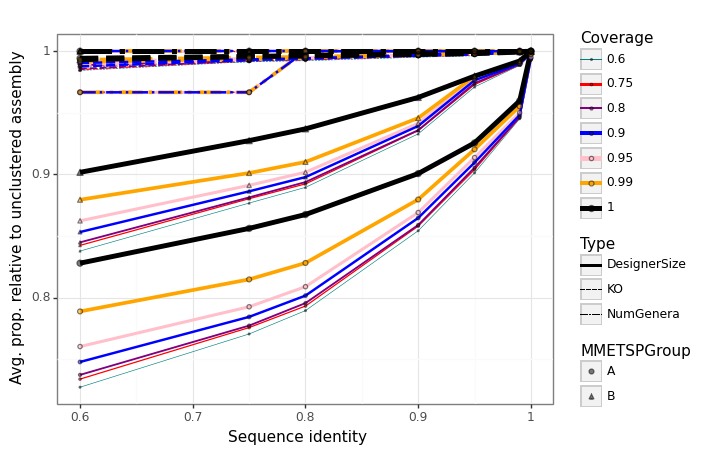

<ggplot: (2932406791665)>

In [30]:
for_plot["CoverageCat"] = for_plot.Coverage + for_plot.Type + for_plot.MMETSPGroup
cov_plot = (plotnine.ggplot(for_plot) + 
 plotnine.geom_line(plotnine.aes(x = "SeqID", y = "Compare", size = "Coverage", 
                                 group = "CoverageCat", color = "Coverage",linetype="Type")) +
 plotnine.geom_point(plotnine.aes(x = "SeqID", y = "Compare", size = "Coverage", fill = "Coverage", 
                                  shape = "MMETSPGroup"),
                     alpha = 0.5) +
 #plotnine.facets.facet_wrap("MMETSPGroup") + 
 plotnine.theme_bw() +
 plotnine.ylab("Avg. prop. relative to unclustered assembly") + 
 plotnine.scale_fill_manual(values = ["teal","red","purple","blue","pink","orange","black"], name = "")+ 
 plotnine.scale_color_manual(values = ["teal","red","purple","blue","pink","orange","black"], name="") + 
 plotnine.scale_size_manual(breaks=["0.6","0.75","0.8","0.9","0.95","0.99","1"],
                     values=[0.25,0.5,0.75,1,1.25,1.5,2],labels=["0.6","0.75","0.8","0.9","0.95","0.99","1"]) +
 plotnine.xlab("Sequence identity"))
plotnine.ggsave(cov_plot, os.path.join("..","figures","Supp-coverage_plot.png"), dpi=400)
cov_plot

In [31]:
latex_table_comm

,MMETSPGroup,Community,DesignerContigs,DesignerSize,NumGenera,NumSpecies,NumKOs
0,A,1,53239 $ \pm $ 5160,33.1 $ \pm $ 2.9,3.5 $ \pm $ 0.6,3.8 $ \pm $ 0.5,4347.8 $ \pm $ 636.0
1,A,2,44797 $ \pm $ 3236,25.7 $ \pm $ 2.2,3.0 $ \pm $ 0.8,3.2 $ \pm $ 0.5,4676.8 $ \pm $ 251.1
2,A,3,51653 $ \pm $ 4847,29.1 $ \pm $ 3.3,4.0 $ \pm $ 0.8,4.2 $ \pm $ 1.0,5108.2 $ \pm $ 98.4
3,A,4,51051 $ \pm $ 6771,29.2 $ \pm $ 5.0,4.0 $ \pm $ 0.8,5.2 $ \pm $ 1.0,5073.0 $ \pm $ 87.3
4,A,5,44538 $ \pm $ 5114,25.5 $ \pm $ 2.6,3.2 $ \pm $ 0.5,3.5 $ \pm $ 0.6,4865.0 $ \pm $ 265.8
5,A,6,55707 $ \pm $ 2467,32.1 $ \pm $ 1.5,4.8 $ \pm $ 0.5,6.2 $ \pm $ 0.5,5130.2 $ \pm $ 170.1
6,B,1,50243 $ \pm $ 7228,32.1 $ \pm $ 4.6,4.0 $ \pm $ 0.0,4.0 $ \pm $ 0.0,5178.5 $ \pm $ 141.3
7,B,2,43564 $ \pm $ 4108,26.6 $ \pm $ 3.2,3.5 $ \pm $ 1.0,3.5 $ \pm $ 1.0,4852.8 $ \pm $ 118.2
8,B,3,44071 $ \pm $ 8863,26.8 $ \pm $ 6.9,4.8 $ \pm $ 1.0,4.8 $ \pm $ 1.0,5037.5 $ \pm $ 317.3
9,B,4,48771 $ \pm $ 7071,29.8 $ \pm $ 5.1,6.2 $ \pm $ 0.5,6.2 $ \pm $ 0.5,5319.8 $ \pm $ 144.4


## get file sizes for CAG assemblies

In [33]:
cag_sizes=pd.DataFrame()
designer_sizes=pd.DataFrame()
jeukebox_dirs = [curr for curr in os.listdir(base_dir) if "jEUKebox" in curr]

for jeukebox_dir in jeukebox_dirs:
    sourmash_file = os.path.join(base_dir, jeukebox_dir, "sourmash_MMETSP", "all.csv")
    #if jeukebox_dir == "jEUKebox-Trial2-CommB":
    #    continue
    #print(jeukebox_dir,"starting")
    if os.path.isfile(sourmash_file):
        
        if not os.path.isdir(os.path.join(base_dir, jeukebox_dir, 
                             "sourmash_MMETSP")):
            continue
        #print(jeukebox_dir,"passed sourmash",flush=True)
        sourmash_file = pd.read_csv(os.path.join(base_dir, jeukebox_dir, 
                                                 "sourmash_MMETSP", "all.csv"))
        community_file = pd.read_csv(os.path.join(base_dir, jeukebox_dir, 
                                                  "03-community_spec", "communities.csv"))

        #print(final_scores,flush=True)
        prot_clust_dir = os.path.join(base_dir, jeukebox_dir,
                                      "eukrhythmic_assembly",
                                      "intermediate-files",
                                      "03-merge", "07-CAG")
        if not os.path.isdir(prot_clust_dir):
            continue
            
        for sim_file in os.listdir(prot_clust_dir):
            if "fasta" not in sim_file:
                continue
                
                
            comm_num = sim_file.split("sim_raw_reads_")[-1].split("_")[0]
                
            ## STORED CONTIGS FROM DESIGNER ASSEMBLY
            designer_contigs = os.path.join(base_dir, jeukebox_dir, 
                                                      "06-designer_assemblies",
                                                      "designer_assembly_" + str(comm_num) + ".fasta")
            designer_size = os.path.getsize(designer_contigs)
            des_length_distro = [len(r.seq) for r in SeqIO.parse(designer_contigs, "fasta")]
            des_gc_content = [r.seq.count("G") + r.seq.count("C") for r in SeqIO.parse(designer_contigs, "fasta")]
            des_ids = [r.id for r in SeqIO.parse(designer_contigs, "fasta")]
            
            ## WHAT'S INSIDE THE CAG ASSEMBLY
            cag_assembly = os.path.join(prot_clust_dir,sim_file)
            cag_length_distro = [len(r.seq) for r in SeqIO.parse(cag_assembly, "fasta")]
            cag_gc_content = [r.seq.count("G") + r.seq.count("C") for r in SeqIO.parse(cag_assembly, "fasta")]
            cag_ids = [r.id for r in SeqIO.parse(cag_assembly, "fasta")]
            cag_size = os.path.getsize(cag_assembly)
            
            mmetsp_group = "B"
            if "100k" in jeukebox_dir:
                mmetsp_group = "A"
            
            curr_df = pd.DataFrame({"jEUKebox": [jeukebox_dir] * len(cag_length_distro),
                                    "Representative": cag_ids,
                                    "Sizes": cag_length_distro,
                                    "GC": cag_gc_content,
                                    "Community": comm_num,
                                    "MMETSPGroup": mmetsp_group})
            cag_sizes = pd.concat([cag_sizes,curr_df])
            
            
            curr_df = pd.DataFrame({"jEUKebox": [jeukebox_dir] * len(des_length_distro),
                                    "Representative": des_ids,
                                    "Sizes": des_length_distro,
                                    "GC": des_gc_content,
                                    "Community": comm_num,
                                    "MMETSPGroup": mmetsp_group})
            designer_sizes = pd.concat([designer_sizes,curr_df])

In [34]:
cag_sizes["Community"] = [int(curr) for curr in cag_sizes["Community"]]

In [37]:
merged_cluster_sizes = pd.merge(cag_sizes, all_results)

In [38]:
def create_list_set(x):
    return "-".join(sorted(list(set([str(curr) for curr in x]))))

def measure_list_set(x):
    return len(list(set(x)))

    #agg({"Assembler_Mem":[create_list_set,measure_list_set]}).
cluster_number_sizes = merged_cluster_sizes.groupby(["Community","MMETSPGroup",
                                                     "Sizes","Representative"])["Assembler_Mem"].\
    apply(lambda x: measure_list_set(x)).\
    reset_index().\
    groupby(["MMETSPGroup","Assembler_Mem"]).agg({"Sizes":["mean","std","min","max","sem"]}).reset_index()

cluster_number_sizes.columns = [' '.join(col).strip() for col in cluster_number_sizes.columns.values]

In [39]:
cluster_number_boxplot = merged_cluster_sizes.groupby(["Community","MMETSPGroup",
                                                     "Sizes","Representative"])["Assembler_Mem"].\
    apply(lambda x: measure_list_set(x)).\
    reset_index().\
    groupby(["MMETSPGroup","Assembler_Mem","Community"]).describe().reset_index()

cluster_number_boxplot.columns = [' '.join(col).strip() for col in cluster_number_boxplot.columns.values]

In [46]:
cluster_number_all = merged_cluster_sizes.groupby(["Community","MMETSPGroup",
                                                   "Sizes","Representative"])["Assembler_Mem"].\
    apply(lambda x: measure_list_set(x)).reset_index()

cluster_number_all.head()

,Community,MMETSPGroup,Sizes,Representative,Assembler_Mem
0,1,A,56,spades_sim_raw_reads_1_NODE_31802_length_56_co...,1
1,1,A,56,spades_sim_raw_reads_1_NODE_33436_length_56_co...,1
2,1,A,56,spades_sim_raw_reads_1_NODE_39136_length_56_co...,1
3,1,A,57,spades_sim_raw_reads_1_NODE_33434_length_57_co...,1
4,1,A,57,spades_sim_raw_reads_1_NODE_33435_length_57_co...,1


In [48]:
from scipy.stats import ttest_ind,ttest_rel
import statsmodels

cat1 = cluster_number_all[(cluster_number_all['Assembler_Mem']==1)]
cat2 = cluster_number_all[(cluster_number_all['Assembler_Mem']==4)]

print("T-test:", ttest_ind(cat1['Sizes'], cat2['Sizes'], equal_var=False))

print("Z-test:", statsmodels.stats.weightstats.ztest(cat1['Sizes'], cat2['Sizes']))

print("KS-test:", scipy.stats.ks_2samp(np.array(cat1['Sizes']), np.array(cat2['Sizes'])))

T-test: Ttest_indResult(statistic=-516.0676996823638, pvalue=0.0)
Z-test: (-542.2152470454523, 0.0)
KS-test: KstestResult(statistic=0.558404582794652, pvalue=0.0)


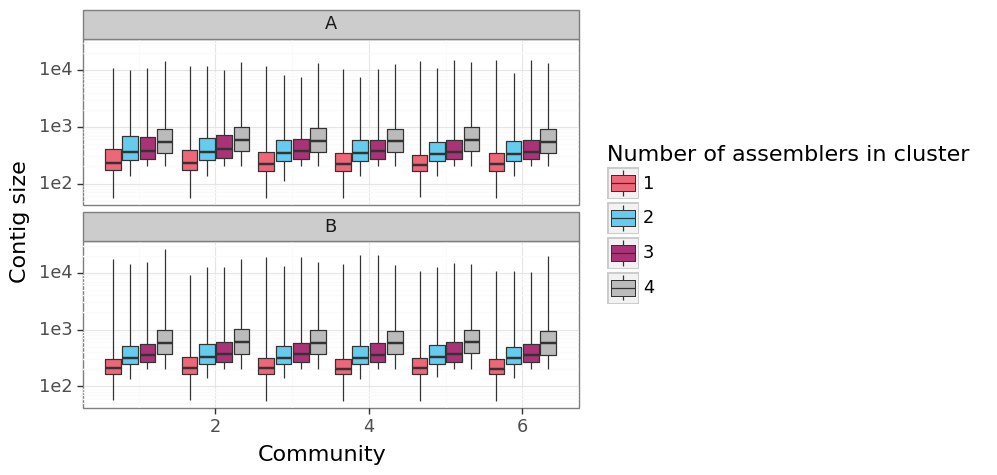

<ggplot: (2932409525944)>

In [41]:
cluster_number_boxplot["AssemblerMemCat"] = [str(curr) for curr in cluster_number_boxplot["Assembler_Mem"]]
size_clust_plot = (plotnine.ggplot(cluster_number_boxplot, plotnine.aes("Community")) +
  plotnine.geom_boxplot(
   plotnine.aes(ymin = "Sizes min", lower = "Sizes 25%", 
                middle = "Sizes 50%", upper = "Sizes 75%", ymax = "Sizes max",
       fill = "AssemblerMemCat"),
   stat = "identity") + plotnine.scale_y_log10() + plotnine.facets.facet_wrap("MMETSPGroup",ncol=1) +
   plotnine.theme_bw(base_size=16) +
   plotnine.scale_fill_manual(values = ["#EE6677",'#66CCEE', '#AA3377', '#BBBBBB'],
                              name = "Number of assemblers in cluster") + 
   plotnine.ylab("Contig size")
)
#plotnine.ggsave(size_clust_plot, filename = "SizeOfClusters_ContigSize.png", dpi=400,width=6,height=4,units="in")
size_clust_plot

In [45]:
cluster_number_boxplot = merged_cluster_sizes.groupby(["Sizes","Representative"])["Assembler_Mem"].\
    apply(lambda x: measure_list_set(x)).\
    reset_index().\
    groupby(["Assembler_Mem"]).describe().reset_index()

cluster_number_boxplot.columns = [' '.join(col).strip() for col in cluster_number_boxplot.columns.values]
cluster_number_boxplot

,Assembler_Mem,Sizes count,Sizes mean,Sizes std,Sizes min,Sizes 25%,Sizes 50%,Sizes 75%,Sizes max
0,1,1042507.0,351.050872,418.191773,56.0,167.0,214.0,334.0,19049.0
1,2,321191.0,525.083517,533.705518,111.0,250.0,332.0,559.0,21000.0
2,3,455414.0,563.949040,570.165934,200.0,268.0,367.0,599.0,21016.0
3,4,814559.0,774.245602,641.026035,200.0,364.0,573.0,960.0,26486.0
